<a href="https://colab.research.google.com/github/AnhQuocVo/ML-for-Research-Paper/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# Replace 'my_data.csv' with the actual path to your file in Google Drive
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RPaper/251124_data.csv')
display(data.head())

,country_code,year,gdp_growth,gdp,gdp_pc,gdp_pc_growth,control_of_corruption,government_effectiveness,political_stability,regulatory_quality,...,Pillar_RegEfficiency,Pillar_MktOpenness,kmeans_group,mean_HC,mean_AI,mean_Eco,z_HC,z_AI,z_Eco,missing_data
0,ABW,1997,7.04687,3.967810e+09,17750.000,2.978400,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,-0.256691,NaN,1
1,ABW,1998,1.99198,4.046850e+09,18828.100,-0.487160,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,-0.256691,NaN,1
2,ABW,1999,1.23804,4.096950e+09,19216.199,-0.125966,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,-0.256691,NaN,1
3,ABW,2000,7.62292,4.409260e+09,20681.000,6.519220,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,-0.256691,NaN,1
4,ABW,2001,4.18200,4.593650e+09,20740.100,3.212410,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,-0.256691,NaN,1


In [8]:
choose_columns = ["country_id", "year", "gdp_pc_growth",
                  # HC_Index
                  'HC_Index', "avg_years_schooling", "expected_years_schooling", "ter_enr", "edu_exp",

                  #economicfreedom
                  "economicfreedom", 'Pillar_RuleOfLaw', 'Pillar_GovSize', 'Pillar_RegEfficiency', 'Pillar_MktOpenness',

                  # AI Innovation
                  "ai_doc1",
                  "industry_value",
                  "fdi",
                  "ln_gdp_pc"]
df = data[choose_columns]
df.head()



,country_id,year,gdp_pc_growth,HC_Index,avg_years_schooling,expected_years_schooling,ter_enr,edu_exp,economicfreedom,Pillar_RuleOfLaw,Pillar_GovSize,Pillar_RegEfficiency,Pillar_MktOpenness,ai_doc1,industry_value,fdi,ln_gdp_pc
0,ABW,1997,2.978400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.133801,12.913900,9.784141
1,ABW,1998,-0.487160,NaN,NaN,NaN,NaN,4.76316,NaN,NaN,NaN,NaN,NaN,NaN,17.510900,6.813150,9.843105
2,ABW,1999,-0.125966,NaN,NaN,NaN,NaN,4.39527,NaN,NaN,NaN,NaN,NaN,NaN,15.548300,27.136801,9.863509
3,ABW,2000,6.519220,NaN,NaN,NaN,NaN,4.71468,NaN,NaN,NaN,NaN,NaN,NaN,13.176000,-6.828730,9.936971
4,ABW,2001,3.212410,NaN,NaN,NaN,28.8601,4.79898,NaN,NaN,NaN,NaN,NaN,NaN,13.054100,-14.075100,9.939824


In [9]:
df_cleaned = df.sort_values(by=['country_id', 'year'])
df_cleaned['ln_gdp_pc_lag'] = df_cleaned.groupby('country_id')['ln_gdp_pc'].shift(1)
df_cleaned.dropna(subset=['ln_gdp_pc_lag'], inplace=True)
# df_cleaned.dropna(subset=['HC_Index','economicfreedom','gdp_pc_growth','ai_doc1'], inplace=True)
df_cleaned.dropna(inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 138 to 7362
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country_id                597 non-null    object 
 1   year                      597 non-null    int64  
 2   gdp_pc_growth             597 non-null    float64
 3   HC_Index                  597 non-null    float64
 4   avg_years_schooling       597 non-null    float64
 5   expected_years_schooling  597 non-null    float64
 6   ter_enr                   597 non-null    float64
 7   edu_exp                   597 non-null    float64
 8   economicfreedom           597 non-null    float64
 9   Pillar_RuleOfLaw          597 non-null    float64
 10  Pillar_GovSize            597 non-null    float64
 11  Pillar_RegEfficiency      597 non-null    float64
 12  Pillar_MktOpenness        597 non-null    float64
 13  ai_doc1                   597 non-null    float64
 14  industry_val

In [10]:

# 1. Define the feature matrix X_aggregated
X_aggregated = df_cleaned[['HC_Index', 'economicfreedom', 'Pillar_RuleOfLaw', 'Pillar_GovSize', 'Pillar_RegEfficiency', 'Pillar_MktOpenness', 'ai_doc1', 'industry_value', 'fdi', 'ln_gdp_pc_lag']]

# 2. Define the target vector y
y = df_cleaned['gdp_pc_growth']

# 4. Instantiate a RandomForestRegressor model
model_aggregated = RandomForestRegressor(random_state=42)

# 5. Train the RandomForestRegressor model
model_aggregated.fit(X_aggregated, y)

# 6. Extract the feature importances
feature_importances_aggregated = model_aggregated.feature_importances_

# 7. Create a pandas Series to store the feature names and their corresponding importances
feature_importance_df_aggregated = pd.DataFrame({
    'Feature': X_aggregated.columns,
    'Importance': feature_importances_aggregated
})

# Sort by importance in descending order
feature_importance_df_aggregated = feature_importance_df_aggregated.sort_values(by='Importance', ascending=False)

print("Feature Importances for Aggregated Model:")
display(feature_importance_df_aggregated)

Feature Importances for Aggregated Model:


,Feature,Importance
7,industry_value,0.161631
8,fdi,0.153295
6,ai_doc1,0.111286
5,Pillar_MktOpenness,0.110646
9,ln_gdp_pc_lag,0.096843
4,Pillar_RegEfficiency,0.087562
3,Pillar_GovSize,0.077018
0,HC_Index,0.074997
2,Pillar_RuleOfLaw,0.067992
1,economicfreedom,0.058731


# Standard Random Forest

In [11]:

# 1. Define the list of features for 'Model_1_Unbundled_HC_Aggregated_Gov'
features_model_1 = ['avg_years_schooling', 'expected_years_schooling', 'ter_enr', 'edu_exp', 'economicfreedom', 'ai_doc1', 'industry_value', 'fdi', 'ln_gdp_pc_lag']
X_model_1 = df_cleaned[features_model_1]

# 2. Define the target variable y_model_1
y_model_1 = df_cleaned['gdp_pc_growth']

# 4. Initialize KFold =with n_splits=10 and shuffle=True
kf = KFold(n_splits=10, shuffle=True, random_state=42) # Added random_state for reproducibility

# 5. Initialize an empty list to store the feature importances from each fold
feature_importances_list_model_1 = []

# 6. Loop through the folds generated by kf.split(X_model_1)
for fold, (train_index, test_index) in enumerate(kf.split(X_model_1)):
    X_train, X_test = X_model_1.iloc[train_index], X_model_1.iloc[test_index]
    y_train, y_test = y_model_1.iloc[train_index], y_model_1.iloc[test_index]

    # b. Instantiate a RandomForestRegressor model
    model_unbundled_hc_aggregated_gov = RandomForestRegressor(n_estimators=100, random_state=42)

    # c. Train the RandomForestRegressor model
    model_unbundled_hc_aggregated_gov.fit(X_train, y_train)

    # d. Extract the feature_importances_
    importances = model_unbundled_hc_aggregated_gov.feature_importances_

    # e. Create a temporary DataFrame for the current fold's feature importances
    fold_importances_df = pd.DataFrame({
        'Feature': X_model_1.columns,
        'Importance': importances,
        'Fold': fold + 1,  # Fold numbers typically start from 1
        'Scenario': 'Model_1_Unbundled_HC_Aggregated_Gov'
    })

    # f. Append this temporary DataFrame to feature_importances_list_model_1
    feature_importances_list_model_1.append(fold_importances_df)

# 7. Concatenate all DataFrames into a single DataFrame
feature_importances_df_model_1 = pd.concat(feature_importances_list_model_1, ignore_index=True)

print("Feature Importances for Model_1_Unbundled_HC_Aggregated_Gov (Cross-Validation):")
display(feature_importances_df_model_1.head())

Feature Importances for Model_1_Unbundled_HC_Aggregated_Gov (Cross-Validation):


,Feature,Importance,Fold,Scenario
0,avg_years_schooling,0.078204,1,Model_1_Unbundled_HC_Aggregated_Gov
1,expected_years_schooling,0.061921,1,Model_1_Unbundled_HC_Aggregated_Gov
2,ter_enr,0.084482,1,Model_1_Unbundled_HC_Aggregated_Gov
3,edu_exp,0.140740,1,Model_1_Unbundled_HC_Aggregated_Gov
4,economicfreedom,0.077631,1,Model_1_Unbundled_HC_Aggregated_Gov


In [12]:
# 1. Define the list of features for 'Model_2_Aggregated_HC_Unbundled_Gov'
features_model_2 = ['HC_Index', 'Pillar_RuleOfLaw', 'Pillar_GovSize', 'Pillar_RegEfficiency', 'Pillar_MktOpenness', 'ai_doc1', 'industry_value', 'fdi', 'ln_gdp_pc_lag']
X_model_2 = df_cleaned[features_model_2]

# 3. Define the target variable y_model_2
y_model_2 = df_cleaned['gdp_pc_growth']

# 4. Initialize KFold with n_splits=10 and shuffle=True
kf = KFold(n_splits=10, shuffle=True, random_state=42) # Added random_state for reproducibility

# 5. Initialize an empty list to store the feature importances from each fold
feature_importances_list_model_2 = []

# 6. Loop through the folds generated by kf.split(X_model_2)
for fold, (train_index, test_index) in enumerate(kf.split(X_model_2)):
    X_train, X_test = X_model_2.iloc[train_index], X_model_2.iloc[test_index]
    y_train, y_test = y_model_2.iloc[train_index], y_model_2.iloc[test_index]

    # b. Instantiate a RandomForestRegressor model
    model_aggregated_hc_unbundled_gov = RandomForestRegressor(n_estimators=100, random_state=42)

    # c. Train the RandomForestRegressor model
    model_aggregated_hc_unbundled_gov.fit(X_train, y_train)

    # d. Extract the feature_importances_
    importances = model_aggregated_hc_unbundled_gov.feature_importances_

    # e. Create a temporary DataFrame for the current fold's feature importances
    fold_importances_df = pd.DataFrame({
        'Feature': X_model_2.columns,
        'Importance': importances,
        'Fold': fold + 1,  # Fold numbers typically start from 1
        'Scenario': 'Model_2_Aggregated_HC_Unbundled_Gov'
    })

    # f. Append this temporary DataFrame to feature_importances_list_model_2
    feature_importances_list_model_2.append(fold_importances_df)

# 7. Concatenate all DataFrames into a single DataFrame
feature_importances_df_model_2 = pd.concat(feature_importances_list_model_2, ignore_index=True)

print("Feature Importances for Model_2_Aggregated_HC_Unbundled_Gov (Cross-Validation):")
display(feature_importances_df_model_2.head())

Feature Importances for Model_2_Aggregated_HC_Unbundled_Gov (Cross-Validation):


,Feature,Importance,Fold,Scenario
0,HC_Index,0.081211,1,Model_2_Aggregated_HC_Unbundled_Gov
1,Pillar_RuleOfLaw,0.075460,1,Model_2_Aggregated_HC_Unbundled_Gov
2,Pillar_GovSize,0.093640,1,Model_2_Aggregated_HC_Unbundled_Gov
3,Pillar_RegEfficiency,0.085634,1,Model_2_Aggregated_HC_Unbundled_Gov
4,Pillar_MktOpenness,0.109457,1,Model_2_Aggregated_HC_Unbundled_Gov


In [13]:
# 1. Define the list of features for 'Model_3_Fully_Unbundled_All'
features_model_3 = ['avg_years_schooling', 'expected_years_schooling', 'ter_enr', 'edu_exp', 'Pillar_RuleOfLaw', 'Pillar_GovSize', 'Pillar_RegEfficiency', 'Pillar_MktOpenness', 'ai_doc1', 'industry_value', 'fdi', 'ln_gdp_pc_lag']
X_model_3 = df_cleaned[features_model_3]

# 2. Define the target variable y_model_3
y_model_3 = df_cleaned['gdp_pc_growth']

# 3. Initialize KFold with n_splits=10 and shuffle=True
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 4. Initialize an empty list to store the feature importances from each fold
feature_importances_list_model_3 = []

# 5. Loop through the folds generated by kf.split(X_model_3)
for fold, (train_index, test_index) in enumerate(kf.split(X_model_3)):
    X_train, X_test = X_model_3.iloc[train_index], X_model_3.iloc[test_index]
    y_train, y_test = y_model_3.iloc[train_index], y_model_3.iloc[test_index]

    # b. Instantiate a RandomForestRegressor model
    model_fully_unbundled_all = RandomForestRegressor(n_estimators=100, random_state=42)

    # c. Train the RandomForestRegressor model
    model_fully_unbundled_all.fit(X_train, y_train)

    # d. Extract the feature_importances_
    importances = model_fully_unbundled_all.feature_importances_

    # e. Create a temporary DataFrame for the current fold's feature importances
    fold_importances_df = pd.DataFrame({
        'Feature': X_model_3.columns,
        'Importance': importances,
        'Fold': fold + 1,  # Fold numbers typically start from 1
        'Scenario': 'Model_3_Fully_Unbundled_All'
    })

    # f. Append this temporary DataFrame to feature_importances_list_model_3
    feature_importances_list_model_3.append(fold_importances_df)

# 6. Concatenate all DataFrames into a single DataFrame
feature_importances_df_model_3 = pd.concat(feature_importances_list_model_3, ignore_index=True)

print("Feature Importances for Model_3_Fully_Unbundled_All (Cross-Validation):")
display(feature_importances_df_model_3.head())

Feature Importances for Model_3_Fully_Unbundled_All (Cross-Validation):


,Feature,Importance,Fold,Scenario
0,avg_years_schooling,0.059713,1,Model_3_Fully_Unbundled_All
1,expected_years_schooling,0.045003,1,Model_3_Fully_Unbundled_All
2,ter_enr,0.061169,1,Model_3_Fully_Unbundled_All
3,edu_exp,0.108514,1,Model_3_Fully_Unbundled_All
4,Pillar_RuleOfLaw,0.055141,1,Model_3_Fully_Unbundled_All


In [14]:
all_feature_importances_df = pd.concat([
    feature_importances_df_model_1,
    feature_importances_df_model_2,
    feature_importances_df_model_3
], ignore_index=True)

print("Concatenated DataFrame head:")
display(all_feature_importances_df.head())

Concatenated DataFrame head:


,Feature,Importance,Fold,Scenario
0,avg_years_schooling,0.078204,1,Model_1_Unbundled_HC_Aggregated_Gov
1,expected_years_schooling,0.061921,1,Model_1_Unbundled_HC_Aggregated_Gov
2,ter_enr,0.084482,1,Model_1_Unbundled_HC_Aggregated_Gov
3,edu_exp,0.140740,1,Model_1_Unbundled_HC_Aggregated_Gov
4,economicfreedom,0.077631,1,Model_1_Unbundled_HC_Aggregated_Gov


In [15]:
aggregated_importances = all_feature_importances_df.groupby(['Scenario', 'Feature'])['Importance'].agg(['mean', 'std']).reset_index()
aggregated_importances.rename(columns={'mean': 'Mean Importance', 'std': 'Std Dev Importance'}, inplace=True)

print("Aggregated Feature Importances (head):")
display(aggregated_importances.head())

Aggregated Feature Importances (head):


,Scenario,Feature,Mean Importance,Std Dev Importance
0,Model_1_Unbundled_HC_Aggregated_Gov,ai_doc1,0.117086,0.007714
1,Model_1_Unbundled_HC_Aggregated_Gov,avg_years_schooling,0.085035,0.006954
2,Model_1_Unbundled_HC_Aggregated_Gov,economicfreedom,0.080929,0.003606
3,Model_1_Unbundled_HC_Aggregated_Gov,edu_exp,0.137501,0.009401
4,Model_1_Unbundled_HC_Aggregated_Gov,expected_years_schooling,0.066616,0.004818


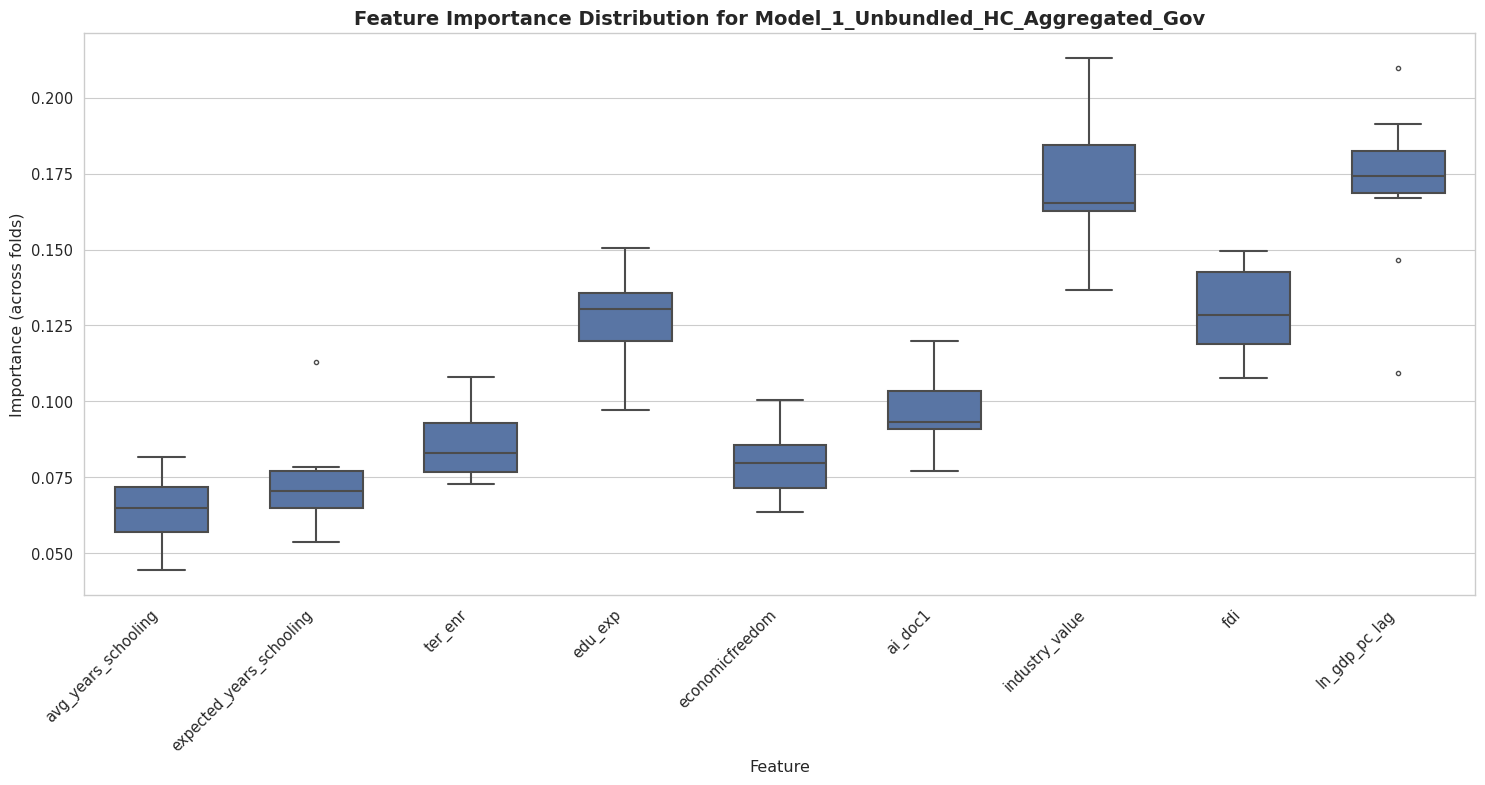

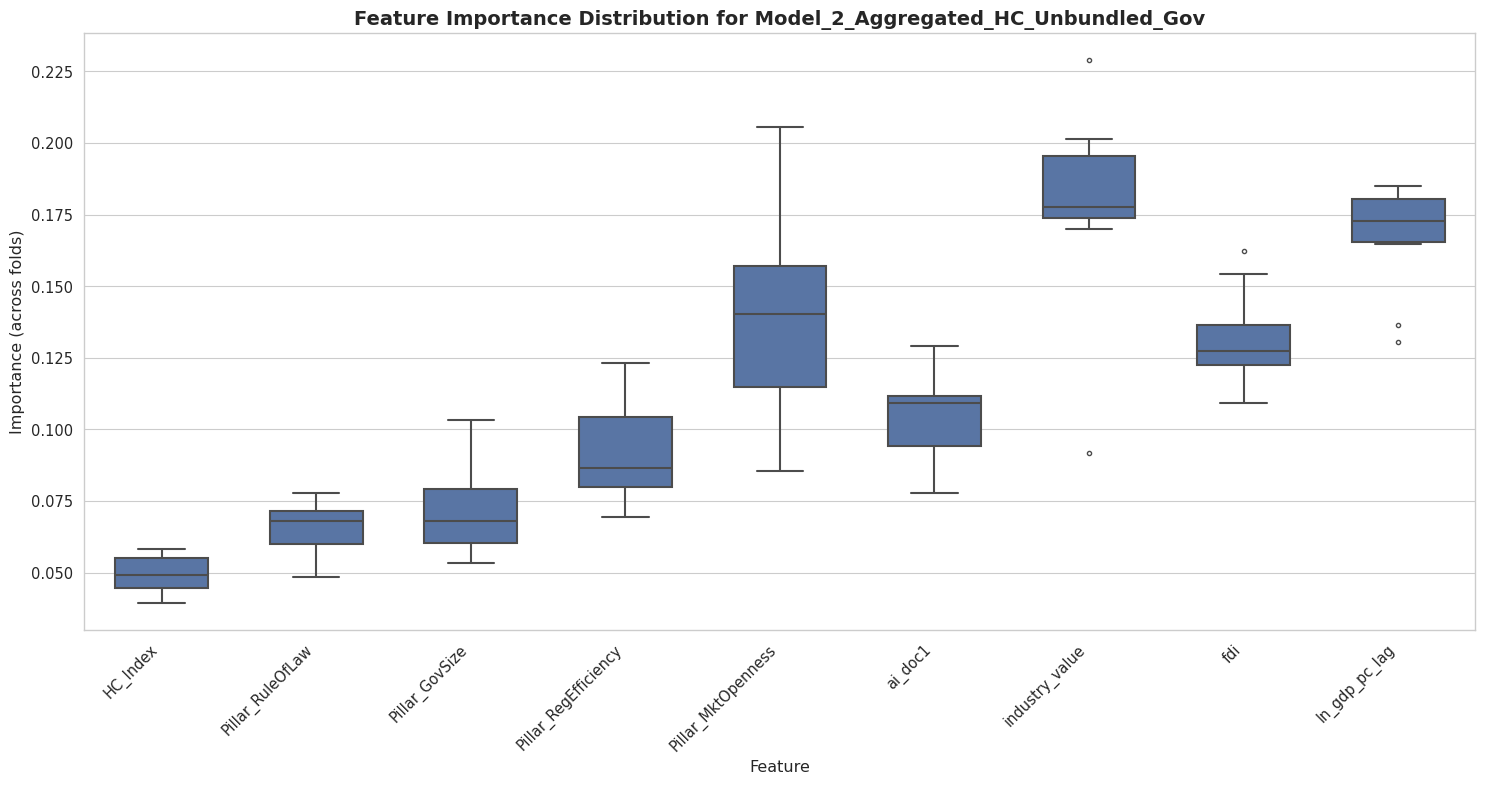

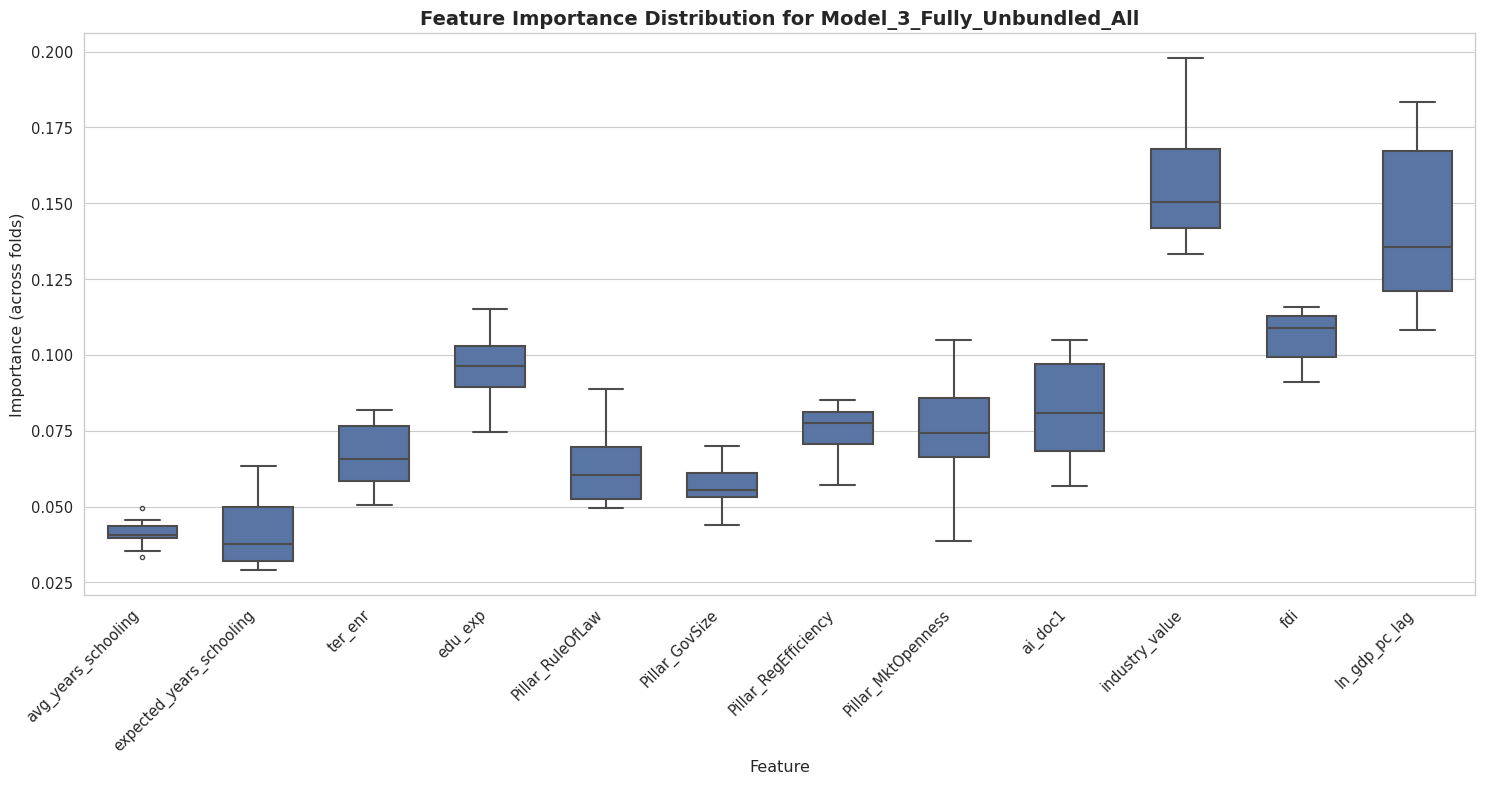

In [35]:
# Get unique scenarios
scenarios = all_feature_importances_df['Scenario'].unique()

sns.set_style("whitegrid") # Nền trắng, có lưới ngang mờ
sns.set_context("paper", font_scale=1.2) # Font chữ chuẩn bài báo

# Loop through each scenario to create a box plot
for scenario in scenarios:
    plt.figure(figsize=(15, 8))
    scenario_data = all_feature_importances_df[all_feature_importances_df['Scenario'] == scenario]

    sns.boxplot(
    data=scenario_data,
    x='Feature',
    y='Importance',
    color='#4C72B0',  # Màu xanh dương đậm solid
    width=0.6,        # Độ rộng hộp vừa phải
    linewidth=1.5,    # Đường viền đậm hơn chút cho rõ
    fliersize=3       # Kích thước điểm outlier nhỏ lại
    )
    plt.title(f'Feature Importance Distribution for {scenario}', fontsize=14, weight='bold')
    plt.xlabel('Feature')
    plt.ylabel('Importance (across folds)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



In [17]:
# 1. Define the feature matrix X_aggregated
X_aggregated = df_cleaned[['HC_Index', 'economicfreedom', 'Pillar_RuleOfLaw', 'Pillar_GovSize', 'Pillar_RegEfficiency', 'Pillar_MktOpenness', 'ai_doc1', 'industry_value', 'fdi', 'ln_gdp_pc_lag']]

# 2. Define the target vector y
y = df_cleaned['gdp_pc_growth']

# 3. Instantiate an xgb.XGBRegressor model
model_aggregated = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 4. Train the XGBRegressor model
model_aggregated.fit(X_aggregated, y)

# 5. Extract the feature importances
feature_importances_aggregated = model_aggregated.feature_importances_

# 6. Create a pandas DataFrame to store the feature names and their corresponding importances
feature_importance_df_aggregated = pd.DataFrame({
    'Feature': X_aggregated.columns,
    'Importance': feature_importances_aggregated
})

# Sort by importance in descending order
feature_importance_df_aggregated = feature_importance_df_aggregated.sort_values(by='Importance', ascending=False)

print("Feature Importances for Aggregated Model:")
display(feature_importance_df_aggregated)

Feature Importances for Aggregated Model:


,Feature,Importance
9,ln_gdp_pc_lag,0.183941
7,industry_value,0.155665
8,fdi,0.124261
5,Pillar_MktOpenness,0.117142
6,ai_doc1,0.089471
4,Pillar_RegEfficiency,0.088639
2,Pillar_RuleOfLaw,0.082264
3,Pillar_GovSize,0.063278
1,economicfreedom,0.055281
0,HC_Index,0.040057


In [18]:
# 1. Define the feature matrix X_aggregated
X_aggregated = df_cleaned[['HC_Index', 'economicfreedom', 'Pillar_RuleOfLaw', 'Pillar_GovSize', 'Pillar_RegEfficiency', 'Pillar_MktOpenness', 'ai_doc1', 'industry_value', 'fdi', 'ln_gdp_pc_lag']]

# 2. Define the target vector y
y = df_cleaned['gdp_pc_growth']

# 3. Instantiate an xgb.XGBRegressor model
model_aggregated = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 4. Train the XGBRegressor model
model_aggregated.fit(X_aggregated, y)

# 5. Extract the feature importances
feature_importances_aggregated = model_aggregated.feature_importances_

# 6. Create a pandas DataFrame to store the feature names and their corresponding importances
feature_importance_df_aggregated = pd.DataFrame({
    'Feature': X_aggregated.columns,
    'Importance': feature_importances_aggregated
})

# Sort by importance in descending order
feature_importance_df_aggregated = feature_importance_df_aggregated.sort_values(by='Importance', ascending=False)

print("Feature Importances for Aggregated Model:")
display(feature_importance_df_aggregated)

Feature Importances for Aggregated Model:


,Feature,Importance
9,ln_gdp_pc_lag,0.183941
7,industry_value,0.155665
8,fdi,0.124261
5,Pillar_MktOpenness,0.117142
6,ai_doc1,0.089471
4,Pillar_RegEfficiency,0.088639
2,Pillar_RuleOfLaw,0.082264
3,Pillar_GovSize,0.063278
1,economicfreedom,0.055281
0,HC_Index,0.040057


# XG Boost

In [23]:

# 1. Define the list of features for 'Model_1_Unbundled_HC_Aggregated_Gov'
# This was already added in the previous step, but explicitly noting its importance here.
features_model_1 = ['avg_years_schooling', 'expected_years_schooling', 'ter_enr', 'edu_exp', 'economicfreedom', 'ai_doc1', 'industry_value', 'fdi', 'ln_gdp_pc_lag']
X_model_1 = df_cleaned[features_model_1].copy() # Use .copy() to avoid SettingWithCopyWarning

# 2. Define the target variable y_model_1
y_model_1 = df_cleaned['gdp_pc_growth']

# 3. Initialize KFold with n_splits=10 and shuffle=True
kf = KFold(n_splits=10, shuffle=True, random_state=42) # Added random_state for reproducibility

# 4. Initialize an empty list to store the feature importances from each fold
feature_importances_list_model_1 = []

# 5. Loop through the folds generated by kf.split(X_model_1)
for fold, (train_index, test_index) in enumerate(kf.split(X_model_1)):
    X_train, X_test = X_model_1.iloc[train_index], X_model_1.iloc[test_index]
    y_train, y_test = y_model_1.iloc[train_index], y_model_1.iloc[test_index]

    # b. Instantiate an XGBRegressor model
    model_unbundled_hc_aggregated_gov = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    # c. Train the XGBRegressor model
    model_unbundled_hc_aggregated_gov.fit(X_train, y_train)

    # d. Extract the feature_importances_
    importances = model_unbundled_hc_aggregated_gov.feature_importances_

    # e. Create a temporary DataFrame for the current fold's feature importances
    fold_importances_df = pd.DataFrame({
        'Feature': X_model_1.columns,
        'Importance': importances,
        'Fold': fold + 1,  # Fold numbers typically start from 1
        'Scenario': 'Model_1_Unbundled_HC_Aggregated_Gov'
    })

    # f. Append this temporary DataFrame to feature_importances_list_model_1
    feature_importances_list_model_1.append(fold_importances_df)

# 6. Concatenate all DataFrames into a single DataFrame
feature_importances_df_model_1 = pd.concat(feature_importances_list_model_1, ignore_index=True)

print("Feature Importances for Model_1_Unbundled_HC_Aggregated_Gov (Cross-Validation):")
display(feature_importances_df_model_1.head())

Feature Importances for Model_1_Unbundled_HC_Aggregated_Gov (Cross-Validation):


,Feature,Importance,Fold,Scenario
0,avg_years_schooling,0.054057,1,Model_1_Unbundled_HC_Aggregated_Gov
1,expected_years_schooling,0.078232,1,Model_1_Unbundled_HC_Aggregated_Gov
2,ter_enr,0.073132,1,Model_1_Unbundled_HC_Aggregated_Gov
3,edu_exp,0.138590,1,Model_1_Unbundled_HC_Aggregated_Gov
4,economicfreedom,0.081533,1,Model_1_Unbundled_HC_Aggregated_Gov


In [24]:
# 1. Define the list of features for 'Model_2_Aggregated_HC_Unbundled_Gov'
features_model_2 = ['HC_Index', 'Pillar_RuleOfLaw', 'Pillar_GovSize', 'Pillar_RegEfficiency', 'Pillar_MktOpenness', 'ai_doc1', 'industry_value', 'fdi', 'ln_gdp_pc_lag']
X_model_2 = df_cleaned[features_model_2].copy() # Use .copy() to avoid SettingWithCopyWarning

# 3. Define the target variable y_model_2
y_model_2 = df_cleaned['gdp_pc_growth']

# 4. Initialize KFold with n_splits=10 and shuffle=True
kf = KFold(n_splits=10, shuffle=True, random_state=42) # Added random_state for reproducibility

# 5. Initialize an empty list to store the feature importances from each fold
feature_importances_list_model_2 = []

# 6. Loop through the folds generated by kf.split(X_model_2)
for fold, (train_index, test_index) in enumerate(kf.split(X_model_2)):
    X_train, X_test = X_model_2.iloc[train_index], X_model_2.iloc[test_index]
    y_train, y_test = y_model_2.iloc[train_index], y_model_2.iloc[test_index]

    # b. Instantiate an XGBRegressor model
    model_aggregated_hc_unbundled_gov = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    # c. Train the XGBRegressor model
    model_aggregated_hc_unbundled_gov.fit(X_train, y_train)

    # d. Extract the feature_importances_
    importances = model_aggregated_hc_unbundled_gov.feature_importances_

    # e. Create a temporary DataFrame for the current fold's feature importances
    fold_importances_df = pd.DataFrame({
        'Feature': X_model_2.columns,
        'Importance': importances,
        'Fold': fold + 1,  # Fold numbers typically start from 1
        'Scenario': 'Model_2_Aggregated_HC_Unbundled_Gov'
    })

    # f. Append this temporary DataFrame to feature_importances_list_model_2
    feature_importances_list_model_2.append(fold_importances_df)

# 7. Concatenate all DataFrames into a single DataFrame
feature_importances_df_model_2 = pd.concat(feature_importances_list_model_2, ignore_index=True)

print("Feature Importances for Model_2_Aggregated_HC_Unbundled_Gov (Cross-Validation):")
display(feature_importances_df_model_2.head())

Feature Importances for Model_2_Aggregated_HC_Unbundled_Gov (Cross-Validation):


,Feature,Importance,Fold,Scenario
0,HC_Index,0.054040,1,Model_2_Aggregated_HC_Unbundled_Gov
1,Pillar_RuleOfLaw,0.076163,1,Model_2_Aggregated_HC_Unbundled_Gov
2,Pillar_GovSize,0.053162,1,Model_2_Aggregated_HC_Unbundled_Gov
3,Pillar_RegEfficiency,0.078202,1,Model_2_Aggregated_HC_Unbundled_Gov
4,Pillar_MktOpenness,0.087575,1,Model_2_Aggregated_HC_Unbundled_Gov


In [25]:
# 1. Define the list of features for 'Model_3_Fully_Unbundled_All'
features_model_3 = ['avg_years_schooling', 'expected_years_schooling', 'ter_enr', 'edu_exp', 'Pillar_RuleOfLaw', 'Pillar_GovSize', 'Pillar_RegEfficiency', 'Pillar_MktOpenness', 'ai_doc1', 'industry_value', 'fdi', 'ln_gdp_pc_lag']
X_model_3 = df_cleaned[features_model_3].copy()

# 2. Define the target variable y_model_3
y_model_3 = df_cleaned['gdp_pc_growth']

# 3. Initialize KFold with n_splits=10 and shuffle=True
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 4. Initialize an empty list to store the feature importances from each fold
feature_importances_list_model_3 = []

# 5. Loop through the folds generated by kf.split(X_model_3)
for fold, (train_index, test_index) in enumerate(kf.split(X_model_3)):
    X_train, X_test = X_model_3.iloc[train_index], X_model_3.iloc[test_index]
    y_train, y_test = y_model_3.iloc[train_index], y_model_3.iloc[test_index]

    # b. Instantiate an XGBRegressor model
    model_fully_unbundled_all = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    # c. Train the XGBRegressor model
    model_fully_unbundled_all.fit(X_train, y_train)

    # d. Extract the feature_importances_
    importances = model_fully_unbundled_all.feature_importances_

    # e. Create a temporary DataFrame for the current fold's feature importances
    fold_importances_df = pd.DataFrame({
        'Feature': X_model_3.columns,
        'Importance': importances,
        'Fold': fold + 1,  # Fold numbers typically start from 1
        'Scenario': 'Model_3_Fully_Unbundled_All'
    })

    # f. Append this temporary DataFrame to feature_importances_list_model_3
    feature_importances_list_model_3.append(fold_importances_df)

# 6. Concatenate all DataFrames into a single DataFrame
feature_importances_df_model_3 = pd.concat(feature_importances_list_model_3, ignore_index=True)

print("Feature Importances for Model_3_Fully_Unbundled_All (Cross-Validation):")
display(feature_importances_df_model_3.head())

Feature Importances for Model_3_Fully_Unbundled_All (Cross-Validation):


,Feature,Importance,Fold,Scenario
0,avg_years_schooling,0.045578,1,Model_3_Fully_Unbundled_All
1,expected_years_schooling,0.063216,1,Model_3_Fully_Unbundled_All
2,ter_enr,0.078428,1,Model_3_Fully_Unbundled_All
3,edu_exp,0.115048,1,Model_3_Fully_Unbundled_All
4,Pillar_RuleOfLaw,0.050339,1,Model_3_Fully_Unbundled_All


In [26]:
all_feature_importances_df = pd.concat([
    feature_importances_df_model_1,
    feature_importances_df_model_2,
    feature_importances_df_model_3
], ignore_index=True)

print("Concatenated DataFrame head:")
display(all_feature_importances_df.head())

Concatenated DataFrame head:


,Feature,Importance,Fold,Scenario
0,avg_years_schooling,0.054057,1,Model_1_Unbundled_HC_Aggregated_Gov
1,expected_years_schooling,0.078232,1,Model_1_Unbundled_HC_Aggregated_Gov
2,ter_enr,0.073132,1,Model_1_Unbundled_HC_Aggregated_Gov
3,edu_exp,0.138590,1,Model_1_Unbundled_HC_Aggregated_Gov
4,economicfreedom,0.081533,1,Model_1_Unbundled_HC_Aggregated_Gov


In [27]:
aggregated_importances = all_feature_importances_df.groupby(['Scenario', 'Feature'])['Importance'].agg(['mean', 'std']).reset_index()
aggregated_importances.rename(columns={'mean': 'Mean Importance', 'std': 'Std Dev Importance'}, inplace=True)

print("Aggregated Feature Importances (head):")
display(aggregated_importances.head())

Aggregated Feature Importances (head):


,Scenario,Feature,Mean Importance,Std Dev Importance
0,Model_1_Unbundled_HC_Aggregated_Gov,ai_doc1,0.096950,0.012793
1,Model_1_Unbundled_HC_Aggregated_Gov,avg_years_schooling,0.064142,0.010923
2,Model_1_Unbundled_HC_Aggregated_Gov,economicfreedom,0.079840,0.011002
3,Model_1_Unbundled_HC_Aggregated_Gov,edu_exp,0.127478,0.014583
4,Model_1_Unbundled_HC_Aggregated_Gov,expected_years_schooling,0.073042,0.016138


In [ ]:
# Get unique scenarios
scenarios = all_feature_importances_df['Scenario'].unique()

# Generate a custom light blue palette
# custom_palette = sns.light_palette('lightblue')

# Loop through each scenario to create a box plot
for scenario in scenarios:
    plt.figure(figsize=(10, 10))
    scenario_data = all_feature_importances_df[all_feature_importances_df['Scenario'] == scenario]

    sns.boxplot(data=scenario_data, x='Feature', y='Importance', palette='viridis')
    plt.title(f'Feature Importance Distribution for {scenario}')
    plt.xlabel('Feature')
    plt.ylabel('Importance (across folds)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Section 2

In [39]:
# 5. Add a new column named 'Type' to the feature_importances_df_model_3 DataFrame (MDI importances)
# Ensure we are working with a copy to avoid SettingWithCopyWarning
m_mdi_importance_df = feature_importances_df_model_3.copy()
m_mdi_importance_df['Type'] = 'MDI Importance'

# To align columns for concatenation and plotting, select relevant columns from permutation_importances_df
# The MDI DataFrame does not have 'Std Dev', so we'll drop it from permutation_importances_df for concatenation
permutation_importances_for_concat = permutation_importances_df[['Feature', 'Importance', 'Fold', 'Type']]

# 6. Concatenate permutation_importances_df and the modified mdi_importance_df into a new DataFrame
combined_importances_df = pd.concat([
    m_mdi_importance_df,
    permutation_importances_for_concat
], ignore_index=True)

print("Combined Feature Importances (head):")
display(combined_importances_df.head())


# 1. Cấu hình Style Học thuật (Academic Style)
sns.set_style("whitegrid") # Nền trắng kẻ lưới ngang
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] # Font chữ chuẩn bài báo
plt.rcParams['font.size'] = 12

plt.figure(figsize=(16, 8), dpi=300) # Kích thước rộng để chứa hết tên biến

# 2. Định nghĩa bảng màu (Palette) chuẩn Academic
# Xanh đậm cho MDI (Lý thuyết) và Đỏ trầm cho Permutation (Thực nghiệm/Kiểm chứng)
academic_palette = {"MDI Importance": "#4C72B0", "Permutation Importance": "#C44E52"}

# 3. Vẽ Box Plot
ax = sns.boxplot(
    data=combined_importances_df, # Tên biến DataFrame chứa kết quả của bạn (hãy đổi nếu khác)
    x='Feature',
    y='Importance',
    hue='Type',
    palette=academic_palette,
    width=0.7,          # Độ rộng hộp
    linewidth=1.2,      # Đường viền mảnh, tinh tế
    fliersize=3         # Điểm outlier nhỏ gọn
)

# 4. Tinh chỉnh thẩm mỹ
plt.title("Comparison of Feature Importances (MDI vs. Permutation) - Model 3", fontsize=16, weight='bold', pad=20)
plt.xlabel("Feature", fontsize=14, weight='bold')
plt.ylabel("Importance Score", fontsize=14, weight='bold')

# Xoay nhãn trục X cho dễ đọc
plt.xticks(rotation=45, ha='right')

# Chỉnh Legend (Chú thích)
plt.legend(title="Importance Type", title_fontsize='12', loc='upper left', frameon=True, shadow=True)

# Thêm đường kẻ ngang mờ tại 0 để dễ so sánh các biến có importance âm (nếu có)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8, alpha=0.5)

# Lưu ảnh
plt.tight_layout()
# plt.savefig("Figure_1_Feature_Importance_Comparison.png", dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'permutation_importances_df' is not defined

In [19]:
import shap

# 1. Initialize a shap.TreeExplainer with the retrained RandomForestRegressor model
explainer = shap.TreeExplainer(model_fully_unbundled_all)

# 2. Calculate SHAP values for the entire X_model_3 dataset
shap_values = explainer.shap_values(X_model_3)

print("SHAP explainer initialized and SHAP values calculated for Model_3_Fully_Unbundled_All.")

SHAP explainer initialized and SHAP values calculated for Model_3_Fully_Unbundled_All.


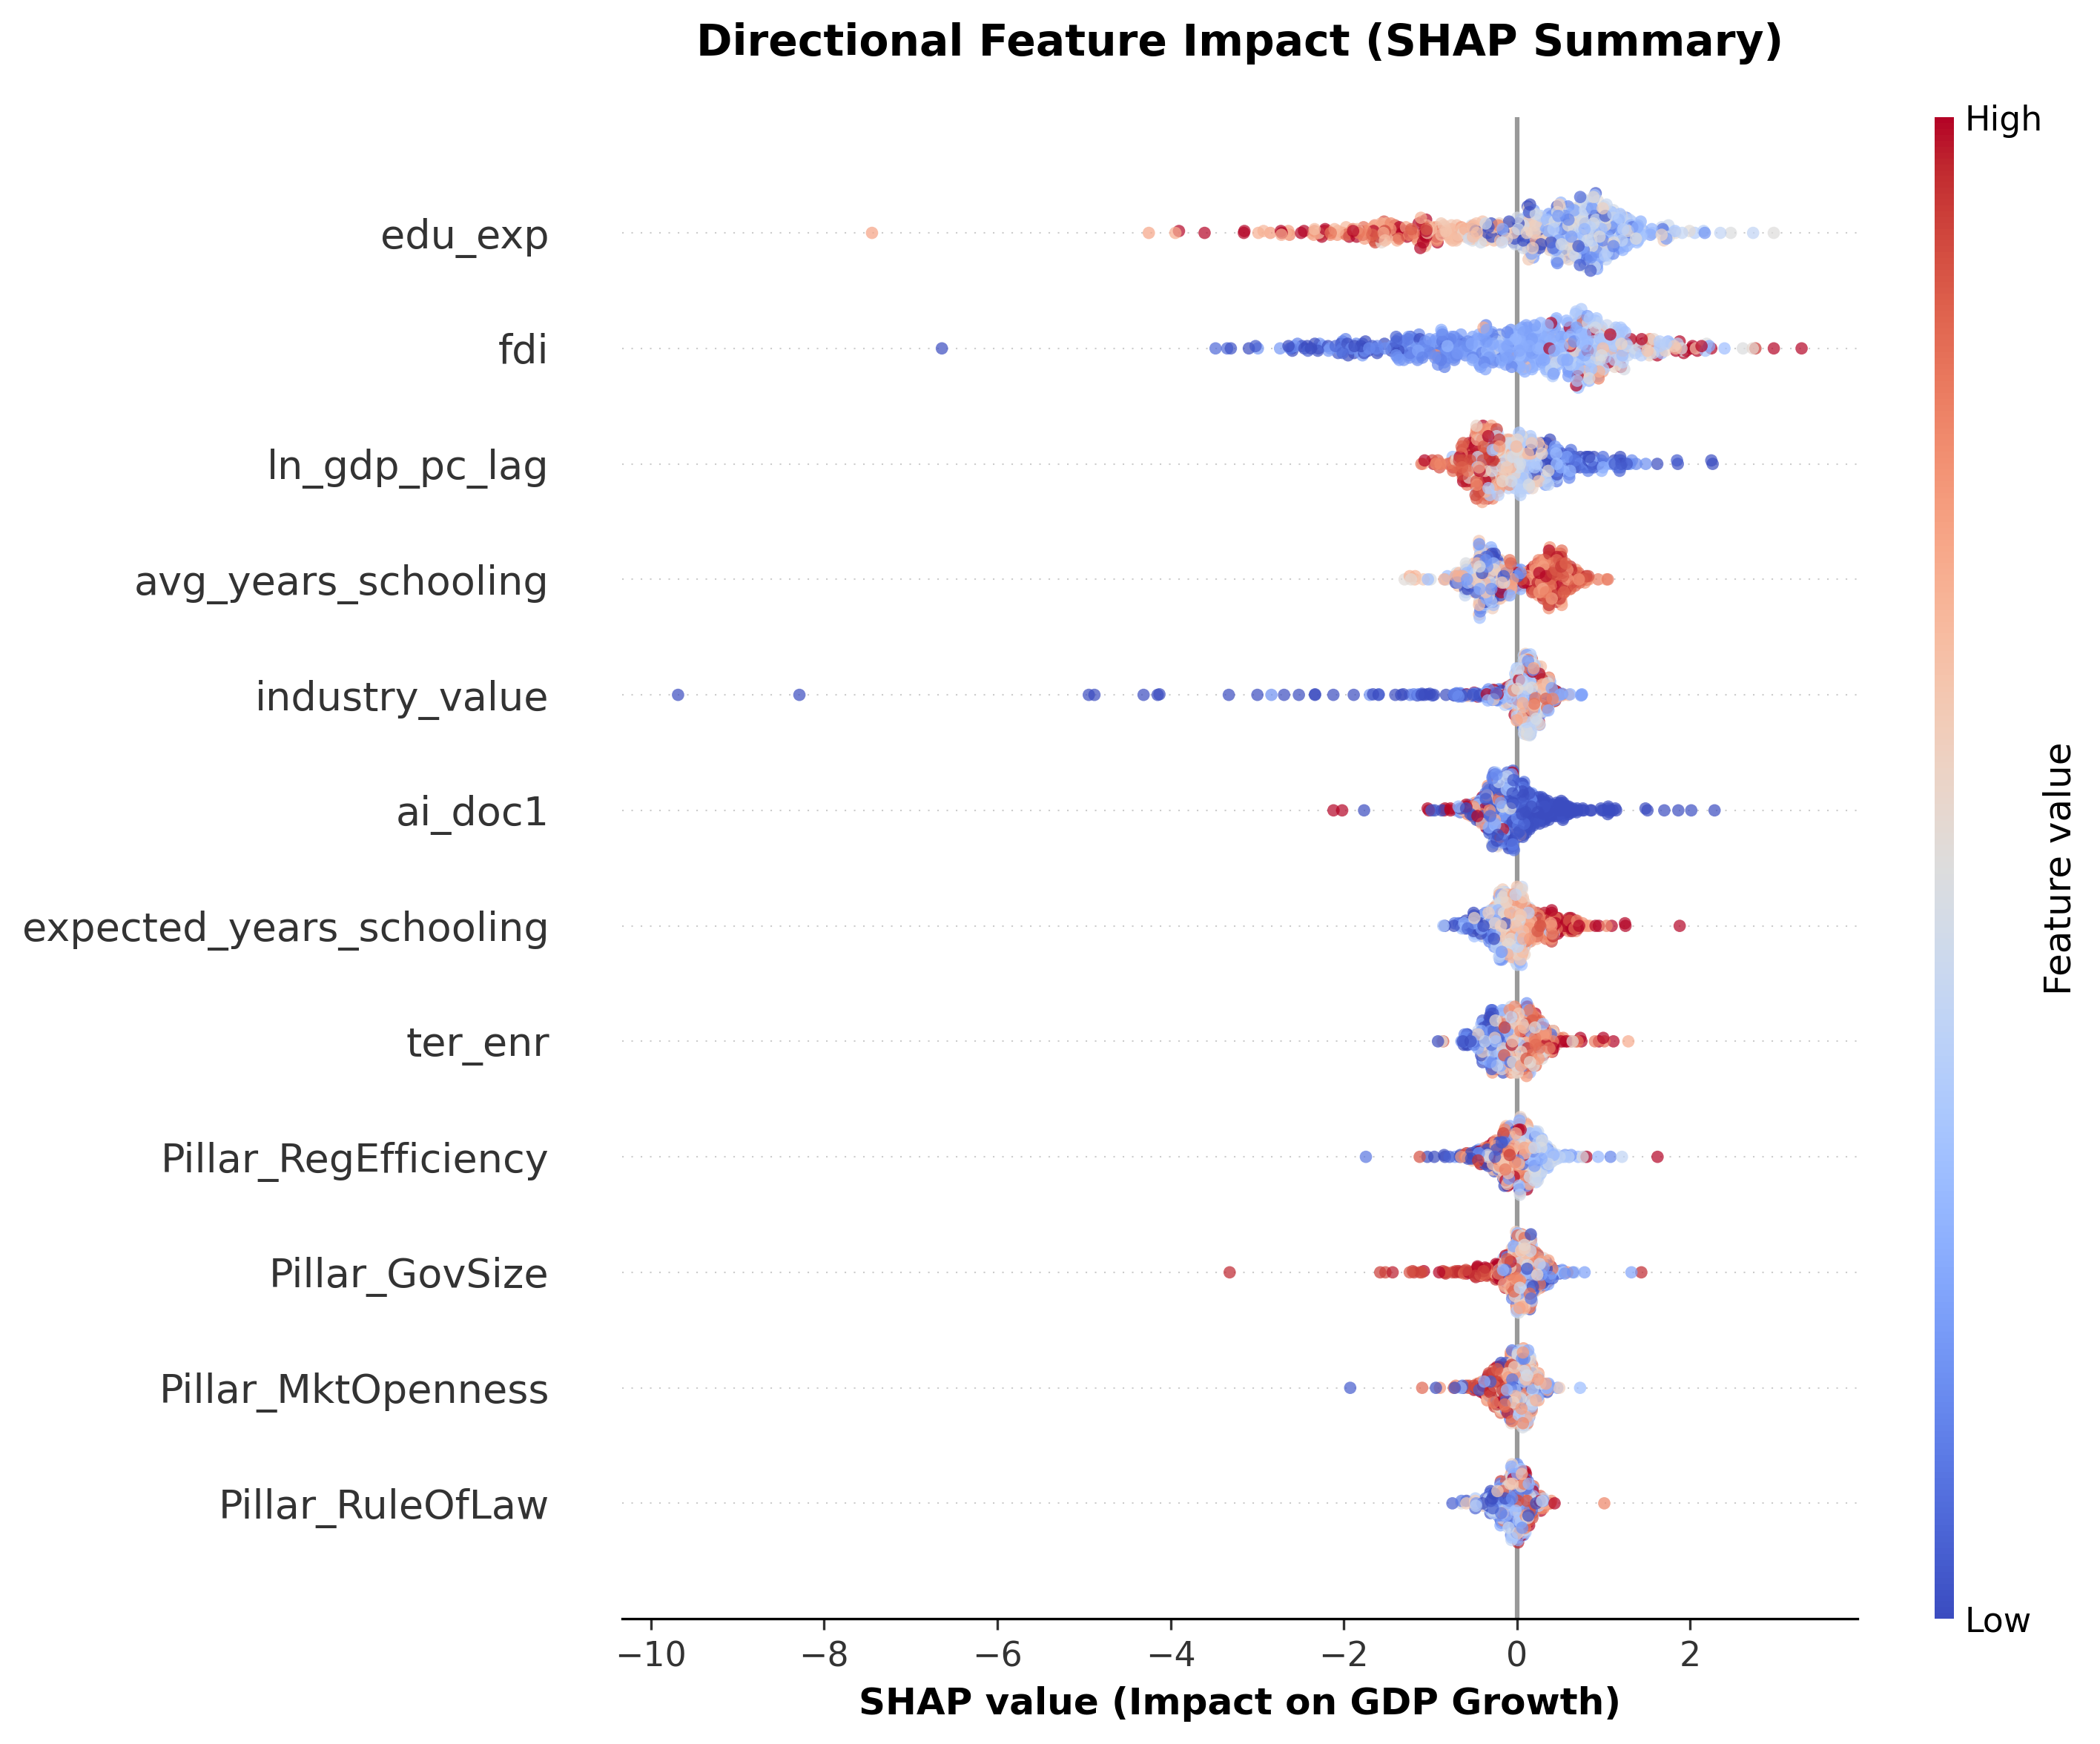

In [31]:
# 1. Cấu hình Style chung (Academic Style)
plt.rcParams['font.family'] = 'serif'       # Dùng font có chân (như Times New Roman)
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 12              # Cỡ chữ dễ đọc
plt.figure(figsize=(10, 8), dpi=300)        # Độ phân giải cao (300 DPI) cho in ấn

# 2. Vẽ SHAP Summary Plot với tùy chỉnh
# Giả sử 'explainer' và 'X_test' đã có từ bước trước
# shap_values = explainer(X_test)

shap.summary_plot(
    shap_values,
    X_model_3,
    show=False,                  # Để ta có thể chỉnh sửa thêm bằng matplotlib
    cmap="coolwarm",             # Dùng màu Xanh-Đỏ chuẩn mực (Blue-Red) thay vì Hồng-Xanh neon
    alpha=0.7,                   # Độ trong suốt để nhìn rõ các điểm chồng lên nhau
    plot_size=(10, 8)
)

# 3. Tinh chỉnh thẩm mỹ
ax = plt.gca()
ax.set_xlabel("SHAP value (Impact on GDP Growth)", fontsize=12, weight='bold')
ax.set_title("Directional Feature Impact (SHAP Summary)", fontsize=14, weight='bold', pad=20)

# Bỏ khung viền trên và phải cho thoáng (Minimalist)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Lưu ảnh
plt.tight_layout()
# plt.savefig("Figure_2_SHAP_Summary_Academic.png", dpi=300, bbox_inches='tight')
plt.show()

# Generate Picture For Paper